### Download data and organise into folders

In [ ]:
%%bash

mkdir data/images
mkdir data/models
mkdir data/predictions

cd data
unzip test.zip -d images
unzip train.zip -d images

cd images
mkdir valid
mkdir valid/cats
mkdir valid/dogs
mkdir train/cats
mkdir train/dogs
mkdir test/unknown

mkdir sample
mkdir sample/train
mkdir sample/test
mkdir sample/valid
mkdir sample/train/cats
mkdir sample/train/dogs
mkdir sample/valid/cats
mkdir sample/valid/dogs
mkdir sample/test/unknown

ls train | grep cat. | xargs -I {} mv train/{} train/cats
ls train | grep dog. | xargs -I {} mv train/{} train/dogs
ls test | xargs -I {} mv test/{} test/unknown

cd train
ls cats | tail -1000 | xargs -I {} mv cats/{} ../valid/cats
ls dogs | tail -1000 | xargs -I {} mv dogs/{} ../valid/dogs
ls cats | tail -50 | xargs -I {} cp cats/{} ../sample/train/cats
ls dogs | tail -50 | xargs -I {} cp dogs/{} ../sample/train/dogs

cd ../valid
ls cats | tail -10 | xargs -I {} cp cats/{} ../sample/valid/cats
ls dogs | tail -10 | xargs -I {} cp dogs/{} ../sample/valid/dogs

cd ../test
ls unknown | tail -10 | xargs -I {} cp unknown/{} ../sample/test/unknown

```
data/
    sample/
        train/
            cats/
            dogs/
        valid/
            dogs/
            cats/
        test/
            cats/
            dogs/
    train/
        cats/
        dogs/
    valid/
        cats/
        dogs/
    test/
        unknown/
```

In [1]:
import os, sys, ujson
from __future__ import division, print_function
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
import bcolz
import itertools
from IPython.display import FileLink

from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

from keras.utils.data_utils import get_file
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical

%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

Using Theano backend.


### Design VGG Model

In [2]:
vgg_image_rgb_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x -= vgg_image_rgb_mean
    return x[:, ::-1] # reverse axis: rgb -> bgr

def ConvBlock(model, n_layers, n_filters):
    for i in range(n_layers):
        model.add(ZeroPadding2D((1, 1))) # add zero padding around image
        model.add(Convolution2D(n_filters, 3, 3, activation='relu')) # 3x3 convolutions with n_filters
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

class Vgg16():
    
    def __init__(self):
        self.vgg_url_prefix = 'http://www.platform.ai/models/'
        self.create()
        self.get_classes()
    
    def create(self):
        model = Sequential()
        model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224))) # (rgb, width, height)
        ConvBlock(model, 2, 64)
        ConvBlock(model, 2, 128)
        ConvBlock(model, 3, 256)
        ConvBlock(model, 3, 512)
        ConvBlock(model, 3, 512)
        model.add(Flatten()) # flattens tensor without affecting first dimension (batch size)
        FCBlock(model)
        FCBlock(model)
        model.add(Dense(1000, activation='softmax'))
        
        # download and assign pretrained weights to model
        fname = 'vgg16.h5'
        model.load_weights(get_file(fname, self.vgg_url_prefix + fname, cache_subdir='models'))
        self.model = model
    
    def get_classes(self):
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.vgg_url_prefix + fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = ujson.load(f)
        # class_dict has value: [{"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], ...]
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
    
    def finetune(self, n_classes):
        self.model.pop() # remove last layer
        for layer in self.model.layers:
            layer.trainable = False # set all layers as non-trainable
        self.model.add(Dense(n_classes, activation='softmax')) # add a dense layer with n_classes output
        self.compile()
    
    def compile(self, lr=0.001):
        self.model.compile(
            optimizer=Adam(lr=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    
    def fit_gen(self, train_batches, valid_batches, n_epochs=1):
        self.model.fit_generator(
            train_batches,
            samples_per_epoch=train_batches.nb_sample,
            validation_data=valid_batches,
            nb_val_samples=valid_batches.nb_sample,
            nb_epoch=n_epochs)
    
    def test_gen(self, test_batches):
        return self.model.predict_generator(test_batches, test_batches.nb_sample)

In [3]:
# initialise model
vgg = Vgg16()
vgg.finetune(2) # finetune model to output only two classes
vgg.model.summary()

/Users/smoussa/anaconda/lib/python3.5/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [28]:
dropout = 0.6
weight_scale = 0.6 / 0.5

# split initial vgg model into a conv model and dense model
layers = vgg.model.layers
last_conv_idx = [idx for idx, layer in enumerate(layers) if type(layer) is Convolution2D][-1]
conv_layers = layers[:last_conv_idx+1]
dense_layers = layers[last_conv_idx+1:]

# redefine the dense part
conv_model = Sequential(conv_layers)
dense_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu', weights=dense_layers[2].get_weights()),
    Dropout(dropout),
    BatchNormalization(),
    Dense(4096, activation='relu', weights=dense_layers[4].get_weights()),
    Dropout(dropout),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

# set all layers in dense model as not trainable except last
for layer in dense_model.layers[:-1]: layer.trainable = False
for layer in dense_model.layers[:-1]:
    if type(layer) is Dense:
        new_weights = [w * weight_scale for w in layer.get_weights()]
        layer.set_weights(new_weights)

conv_model.add(dense_model)
conv_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# load weights

# scale weights

# set trainable to false

# add 2 class dense layer

# compile with Adam optimiser

### Create augmented data (demo)

In [6]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [8]:
gen = image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    channel_shift_range=10.,
    horizontal_flip=True,
    dim_ordering='tf')

In [9]:
# create a batch of a single image (for example purposes)
img = np.expand_dims(ndimage.imread('data/images/sample/train/cats/cat.10898.jpg'), 0)
augmented_images_gen = gen.flow(img)
augmented_images = [next(augmented_images_gen)[0].astype(np.uint8) for i in range(8)]

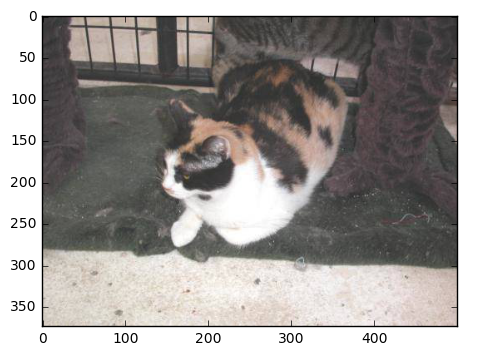

In [10]:
# shot original image
plt.imshow(img[0])

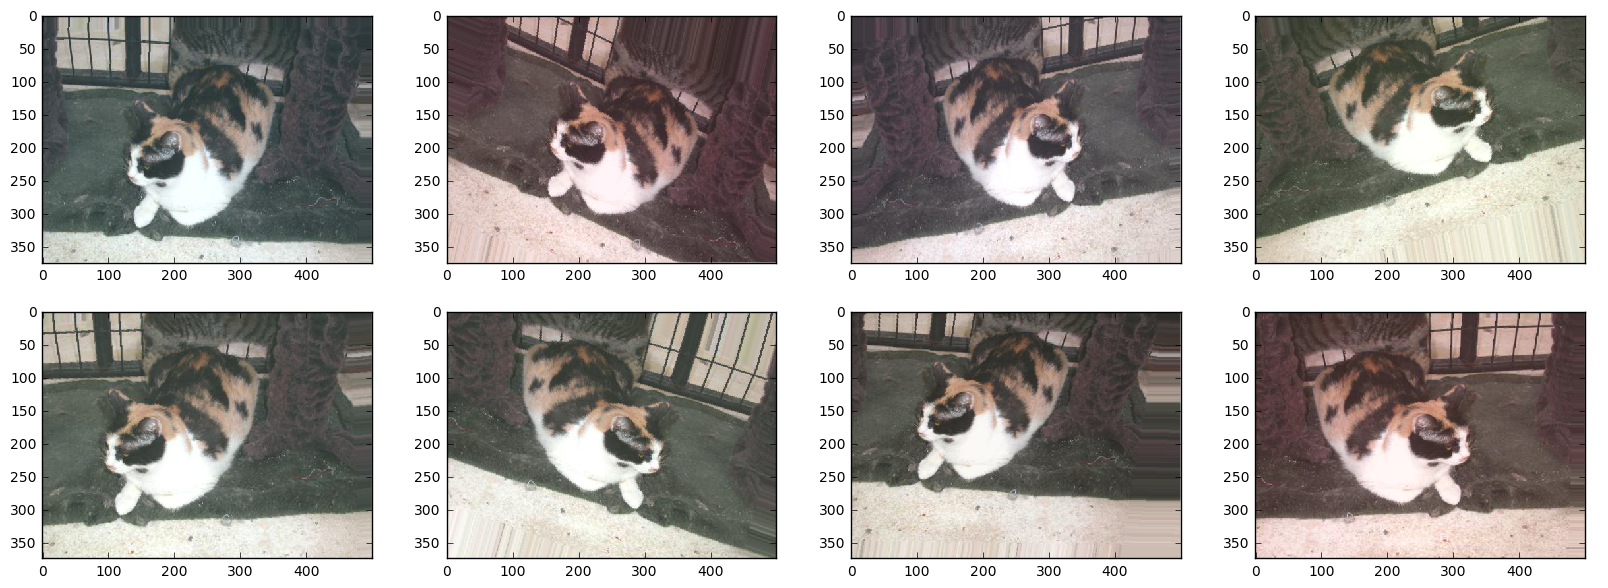

In [11]:
# show augmented versions
plots(augmented_images, (20, 7), 2)

In [12]:
# return back to theano shape dimension ordering
K.set_image_dim_ordering('th')

### Create augmented images (to be used)

In [13]:
aug_gen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.10,
    zoom_range=0.1,
    channel_shift_range=10.,
    horizontal_flip=True)

### Training

In [14]:
images_path = "data/images/sample/"
batch_size = 64
n_epochs = 5
model_name = 'batchnorm'

def save_array(arr, fname):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]
    
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(
        path,
        target_size=(224, 224),
        class_mode=class_mode,
        shuffle=shuffle,
        batch_size=batch_size)

In [15]:
# get training and validation batches (generator)
train_batches = get_batches(images_path + 'train', gen=aug_gen, batch_size=batch_size)
valid_batches = get_batches(images_path + 'valid', batch_size=batch_size)
test_batches = get_batches(images_path + 'test', shuffle=False, batch_size=batch_size, class_mode=None)

train_labels = to_categorical(train_batches.classes)
valid_labels = to_categorical(valid_batches.classes)

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 10 images belonging to 1 classes.


In [17]:
# # precompute convolution features and save
# train_conv_features = conv_model.predict_generator(train_batches, train_batches.nb_sample)
# valid_conv_features = conv_model.predict_generator(valid_batches, valid_batches.nb_sample)

# save_array(train_conv_features, 'data/%s_train_conv_features.bc' % model_name)
# save_array(valid_conv_features, 'data/%s_valid_conv_features.bc' % model_name)

In [18]:
# # load saved convolution features
# train_conv_features = load_array('data/%s_train_conv_features.bc' % model_name)
# valid_conv_features = load_array('data/%s_valid_conv_features.bc' % model_name)

**Train**

In [29]:
# train and save weights per epoch
for i in range(n_epochs):
    print('Running epoch: %d ...' % i)
    conv_model.fit_generator(
            train_batches,
            samples_per_epoch=train_batches.nb_sample,
            validation_data=valid_batches,
            nb_val_samples=valid_batches.nb_sample,
            nb_epoch=1)
    conv_model.save_weights('data/models/%s_%d.h5' % (model_name, i))
print('Completed %d training epochs' % n_epochs)

Running epoch: 0 ...
Epoch 1/1


KeyboardInterrupt: 

In [ ]:
# use saved weights instead of training
conv_model.load_weights('data/models/full_5_epochs_3.h5')

### Prediction

In [ ]:
predictions = conv_model.predict_generator(test_batches, test_batches.nb_sample)
save_array(predictions, 'data/predictions/%s_test_predictions.dat' % model_name)
save_array(test_batches.filenames, 'data/predictions/%s_test_filenames.dat' % model_name)

In [ ]:
predictions # [cat, dog]

In [ ]:
# show a test image
print(test_batches.filenames[0])
Image.open(images_path + 'test/' + test_batches.filenames[5])

### Plotting Validation Predictions

In [ ]:
# predict on some validation data
predictions = conv_model.predict_generator(valid_batches)

In [ ]:
# get true and predicted classes (0=cat, 1=dog)
true_classes = valid_batches.classes
pred_probs = predictions[:,1]
pred_classes = np.round(pred_probs)

In [ ]:
#1. A few correct labels at random
correct_indexes = np.where(pred_classes==true_classes)[0]
print("Found %d correct labels" % len(correct_indexes))
idx = np.random.permutation(correct_indexes)[:4] # show first 4
plots([image.load_img(images_path + 'valid/' + valid_batches.filenames[i]) for i in idx], titles=pred_probs[idx])

In [ ]:
#2. A few incorrect labels at random
incorrect_indexes = np.where(pred_classes!=true_classes)[0]
print("Found %d incorrect labels" % len(incorrect_indexes))
idx = np.random.permutation(incorrect_indexes)[:4] # show first 4
plots([image.load_img(images_path + 'valid/' + valid_batches.filenames[i]) for i in idx], titles=pred_probs[idx])

In [ ]:
#3a. The images we are most confident are cats, and actually are cats
correct_cats = np.where((pred_classes==0) & (pred_classes==true_classes))[0]
print("Found %d confident correct cats" % len(correct_cats))
most_correct_cats = np.argsort(pred_probs[correct_cats])[::-1][:4] # sort by most confident then show first 4
plots([image.load_img(images_path + 'valid/' + valid_batches.filenames[i]) for i in correct_cats[most_correct_cats]],
      titles=pred_probs[correct_cats][most_correct_cats])

In [ ]:
#3b. The images we are most confident are dogs, and actually are dogs
correct_dogs = np.where((pred_classes==1) & (pred_classes==true_classes))[0]
print("Found %d confident correct dogs" % len(correct_dogs))
most_correct_dogs = np.argsort(pred_probs[correct_dogs])[::-1][:4] # sort by most confident then show first 4
plots([image.load_img(images_path + 'valid/' + valid_batches.filenames[i]) for i in correct_dogs[most_correct_dogs]],
      titles=pred_probs[correct_dogs][most_correct_dogs])

In [ ]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((pred_classes==0) & (pred_classes!=true_classes))[0]
print("Found %d incorrect cats" % len(incorrect_cats))
most_incorrect_cats = np.argsort(pred_probs[incorrect_cats])[::-1][:4] # sort by most confident then show first 4
plots([image.load_img(images_path + 'valid/' + valid_batches.filenames[i]) for i in incorrect_cats[most_incorrect_cats]],
      titles=pred_probs[incorrect_cats][most_incorrect_cats])

In [ ]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((pred_classes==1) & (pred_classes!=true_classes))[0]
print("Found %d incorrect dogs" % len(incorrect_dogs))
most_incorrect_dogs = np.argsort(pred_probs[incorrect_dogs])[::-1][:4] # sort by most confident then show first 4
plots([image.load_img(images_path + 'valid/' + valid_batches.filenames[i]) for i in incorrect_dogs[most_incorrect_dogs]],
      titles=pred_probs[incorrect_dogs][most_incorrect_dogs])

In [ ]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
idx = np.argsort(np.abs(pred_probs - 0.5))[:4]
plots([image.load_img(images_path + 'valid/' + valid_batches.filenames[i]) for i in idx], titles=pred_probs[idx])

In [ ]:
# plot confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Dogs vs Cats: Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(valid_batches.class_indices))
plt.xticks(tick_marks, valid_batches.class_indices, rotation=45)
plt.yticks(tick_marks, valid_batches.class_indices)

normalize = False
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Submit predictions to Kaggle

Submission format:
```
imageId, isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

In [ ]:
# Load our test predictions from file
predictions = load_array('data/predictions/%s_test_predictions.dat' % model_name)
filenames = load_array('data/predictions/%s_test_filenames.dat' % model_name)

In [ ]:
# clip very low or very high values
is_dog = predictions[:,1].clip(min=0.05, max=0.95)

# extract image ids from filenames
image_ids = np.array([f.split('/')[-1][:-4] for f in filenames], dtype=np.uint)

In [ ]:
# create a save submission file
submission_fname = 'data/%s_submission.csv' % model_name
submission = np.stack((image_ids, is_dog), axis=1)
np.savetxt(submission_fname, submission, fmt='%d,%.5f', header='id,label', comments='')

# create a file link of the submission file to download and submit to Kaggle
FileLink(submission_fname)